In [49]:
import json
from tqdm import tqdm
text_path = r"/home/kayzhou/zhangyue/text/data_GCN/202010-text.lj"
user_id_set= set()
tweet_id_set = set()
tweet_id_tweet = {}
user_tweet_id = {}
user_id_tag={}
tr_tweet_set=set()
for line in tqdm(open(text_path,"r",encoding="utf8")):
    line= json.loads(line)
    user_id = line["user_id"]
    tweet_id=line["tweet_id"]
    user_id_set.add(user_id)
    tweet_id_set.add(tweet_id)
    tweet_id_tweet[tweet_id]=[line["text"],line["label"]]
    user_tweet_id.setdefault(user_id,set()).add(tweet_id)
    user_id_tag.setdefault(user_id,[]).append(line["label"])
    if line["text"][0:2]=="RT":
        tr_tweet_set.add(tweet_id)
    
    

1123757it [00:16, 70211.84it/s]


In [50]:
len(tr_tweet_set)/len(tweet_id_set)

0.0006416023507028705

In [35]:
from collections import Counter
tag=[]
for i in tweet_id_tweet:
    tag_=tweet_id_tweet[i][1]
    tag.append(tag_)

print(Counter(tag)["JB"])

724057


In [40]:
#对用户进行标记且统计其比例分布
precent_list=[]
j=0
for i in user_id_tag:
    A=Counter(user_id_tag[i])
    precent = A['JB']/len(user_id_tag[i])
    precent_list.append(precent)
    if precent==0.5:
        j=j+1
print(j)
    


4023


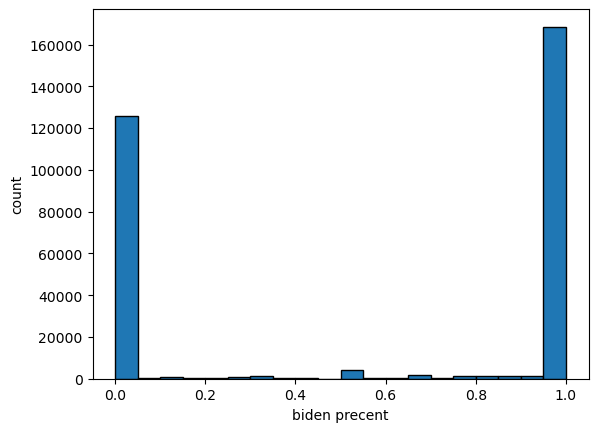

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os #导入os库
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
matplotlib.rcParams['axes.unicode_minus'] = False
# my_x_ticks = np.arange(0, 260, 20)

# # plt.figure(figsize=(6,4))## 设置画布\n",
# plt.xticks(my_x_ticks)
plt.hist(precent_list,edgecolor="black",bins=20)
plt.xlabel("biden precent")
plt.ylabel("count")
plt.show()

In [1]:
# import json
# from tqdm import tqdm
# text_path = r"/home/kayzhou/zhangyue/text/data_GCN/202008-text-v2.lj"
# i=1
# for line in tqdm(open(text_path,"r",encoding="utf8")):
#     line= json.loads(line)
#     i=i+1
#     print(line)
#     if i >= 10:
#         break

8it [00:00, 4771.68it/s]

{'hashtags': [{'text': 'BidenHarris2020'}], 'user_id': '226201248', 'tweet_id': '1300282096334897157', 'text': "@TDN_NOTICIAS @realDonaldTrump This is @realDonaldTrump's America.  #BidenHarris2020", 'label': 'JB'}
{'hashtags': [{'text': 'MAGA2020'}], 'user_id': '1288290125017944064', 'tweet_id': '1300282096091566082', 'text': '@JustInformU @JoeBiden @JoeBiden  if you don’t debate @realDonaldTrump  you definitely shouldn’t be able to be considered a presidential candidate. Also shouldn’t your dementia be checked and disqualify you? Invoking the 25th is their first step. To bad they missed winning first #MAGA2020', 'label': 'DT'}
{'hashtags': [{'text': 'TrumpRiots'}, {'text': 'SaveAmericaVoteDemocrats'}, {'text': 'VoteBidenHarris2020'}], 'user_id': '1253723061330812928', 'tweet_id': '1300282095152099329', 'text': '@mmpadellan Me either. trump* loves the hate and violence. Right?  This is Trump’s America. Save America VOTE DEMOCRATS.  #TrumpRiots  #SaveAmericaVoteDemocrats  #VoteBidenHarr

In [2]:
#不要没有t字段的信息，同时对于有t字段的信息认为被转发文本与转发文本的文本内容一样并共用1个tweet_id
network_path = r"/home/kayzhou/zhangyue/text/data_GCN/202010-network.lj"
user_id_retweeted_user_id = {}
for line in tqdm(open(network_path,"r",encoding="utf8")):
    line= json.loads(line)
    try:
        r_user_id = line["r_uid"]
        user_id = line['uid']
        tweet_id = line["tid"]
        r_tweet_id = line["r_tid"]
        tweet_text = line["t"]
        if  tweet_id in tweet_id_set | r_tweet_id in tweet_id_set:
            user_id_set.add(user_id)
            user_id_set.add(r_user_id)
            tweet_id_tweet[tweet_id]=[tweet_text]
            user_tweet_id.setdefault(user_id,set()).add(tweet_id)
            user_tweet_id.setdefault(r_user_id,set()).add(tweet_id)
            user_id_retweeted_user_id.setdefault(user_id,set()).add(r_user_id)
    except:
        pass
    



126415536it [10:29, 200825.75it/s]


In [ ]:
# network_path = r"E:\学校机器相关\数据\普通方法需要数据\202010-network.lj"
# i=1
# for line in tqdm(open(network_path,"r",encoding="utf8")):
#     line= json.loads(line) 
#     try:
#         r_t = line["r_t"]
#         print(line)
#     except:
#         pass


In [4]:
user_id_list = sorted(list(user_id_set))
tweet_id_list = sorted(list(tweet_id_set))

In [5]:
len(user_id_set),len(tweet_id_set)

(311618, 1123749)

In [17]:
import gc
del user_id_set,tweet_id_set

In [6]:
user_id_mapping = {user_id:i for i,user_id in enumerate(user_id_list)}
tweet_id_mapping = {tweet_id:i+len(user_id_list) for i,tweet_id in enumerate(tweet_id_list)}

In [19]:
del user_id_list,tweet_id_list

对文本进行处理

In [8]:
classfied_hashtag_list = []
for line in open(r"/home/kayzhou/zhangyue/text/data_GCN/top200.txt","r",encoding="utf8"):
    classfied_hashtag = line.strip().split(" ")[0]
    classfied_hashtag_list.append(classfied_hashtag)

In [7]:
# 推文特征嵌入
import collections
import re
import unicodedata
from itertools import chain
from string import punctuation

import numpy as np
from nltk import BigramAssocMeasures, ngrams, precision, recall
from nltk.corpus import stopwords
from nltk.probability import ConditionalFreqDist, FreqDist
from nltk.tokenize.casual import (EMOTICON_RE, HANG_RE, 
                                  TweetTokenizer, _replace_html_entities,
                                  reduce_lengthening, remove_handles)


def read_classified_hashtags(now, label2num=None):
    print("func read_classified_hashtags ...")        
    print("label > num:", label2num)
    
    hts = []
    classified_hts = {i: set() for i in range(len(label2num))}

    for line in open(f"data/{now}/hashtags.txt"):
        if not line.startswith("#"):
            # _ht, _label, _cate = line.strip().split()
            _ht, _label, = line.strip().split()
            # print("hashtag:", _ht, "label:", _label)
            if _label in label2num:
                hts.append(_ht)
                classified_hts[label2num[_label]].add(_ht)
    # print(hts)
    # print(classified_hts)
    return hts, classified_hts

#==============================================================================
# bag of words
#==============================================================================


def bag_of_words(words):
    return dict([(word, True) for word in words])


def bag_of_words_and_bigrams(words):
    bigrams = ngrams(words, 2)
    return bag_of_words(chain(words, bigrams))


def normalize_hashtags(text, ignores):
    """
    Replace Twitter username handles with '#HT'.
    """
    
    def _replace(matched):
        if matched.group(0).lower() in ignores:
            return "#HT"
        else:
            return matched.group(0)

    pattern = re.compile(r"\B#(\w*[A-Za-z_]+\w*)")
    return pattern.sub(_replace, text)


def normalize_urls(text):
    """
    Replace urls with 'URL'.
    """
    # pattern = re.compile(
    #     r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""")
    pattern = re.compile(
        r"""http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"""
    )
    
    # first shorten consecutive punctuation to 3
    # to avoid the pattern to hang in exponential loop in extreme cases.
    text = HANG_RE.sub(r'\1\1\1', text)

    return pattern.sub('URL', text)


class CustomTweetTokenizer(TweetTokenizer):
    """ Custom tweet tokenizer based on NLTK TweetTokenizer"""

    def __init__(self, hashtags=None, preserve_case=False, reduce_len=True, strip_handles=False,
                 normalize_usernames=False, normalize_urls=True):

        TweetTokenizer.__init__(self, preserve_case=preserve_case, reduce_len=reduce_len,
                                strip_handles=strip_handles)

        if hashtags:
            self.hashtags_marked = set(
                ["#" + ht for ht in hashtags]
            )
        else:
            self.hashtags_marked = set()

        self.normalize_urls = normalize_urls
        self.normalize_usernames = normalize_usernames

        # if normalize_usernames:
        #    self.strip_handles = False

        if self.preserve_case:
            self.keep_allupper = True


    def _lowerize(self, word):
        if EMOTICON_RE.search(word):
            return word
        elif word == 'URL' or word == "@USER" or word == "#HT":
            return word
        elif word.isupper():
            return word
        else:
            return word.lower()
    
    
    def tokenize(self, text):
        """
        :param text: str
        :rtype: list(str)
        :return: a tokenized list of strings;

        Normalizes URLs, usernames and word lengthening depending of the
        attributes of the instance.

        """
        # Fix HTML character entities:
        text = _replace_html_entities(text)

        # Remove or replace username handles
        if self.strip_handles:
            text = remove_handles(text)
            
        # elif self.normalize_usernames:
        #     text = normalize_mentions(text)

        # Normalize hashtags, we can't use classified hashtags.
        text = normalize_hashtags(text, self.hashtags_marked)
        
        if self.normalize_urls:
            # Shorten problematic sequences of characters
            text = normalize_urls(text)

        # Normalize word lengthening
        if self.reduce_len:
            text = HANG_RE.sub(r'\1\1\1', text)
            text = reduce_lengthening(text)

        # Tokenize:
        safe_text = HANG_RE.sub(r'\1\1\1', text)
        words = TweetTokenizer().WORD_RE.findall(safe_text)

        # Possibly alter the case, but avoid changing emoticons like :D into :d:
        # lower words but keep words that are all upper cases
        if not self.preserve_case:
            words = [self._lowerize(w) for w in words]

        # print(words)
        return words
# import pickle as pkl
# UNK, PAD = '<UNK>', '<PAD>' 
# def build_tweet_embedding(vocab_path,token,pad_size):
#     words_line = []
#     vocab = pkl.load(open(vocab_path, 'rb'))
# #     print(f"Vocab size: {len(vocab)}")

#     contents = []
#     seq_len = len(token)
#     if pad_size:
#         if len(token) < pad_size:
#             token.extend([PAD] * (pad_size - len(token)))
#         else:
#             token = token[:pad_size]
#             seq_len = pad_size
#     # word to id
#     for word in token:
#         words_line.append(vocab.get(word, vocab.get(UNK)))
#     return words_line 



In [ ]:
# import numpy as np
# def get_words_embeding(glove_file):
#     words_embeding_dict = {}
#     words_embeding_set = set()#别人训练的glove所包含的词集合
#     for word_vector in open(glove_file,"r",encoding='utf-8').readlines():
#         word_vector = word_vector.rstrip().split()
#         #print(word_vector)
#         word = word_vector[0]  #这个零 代表的是索引  下面的 一  也是同样的道理
#         vector = np.asarray(word_vector[1:], "float32")
#         words_embeding_dict[word] = vector
#         words_embeding_set.add(word)
#     return words_embeding_dict,words_embeding_set
# #返回的一个为word和对应的嵌入的字典，另一个为glove别人训练的模型中包含的word
# words_embeding_dict,words_embeding_set = get_words_embeding(r"/home/kayzhou/zhangyue/text/data_ML_ANNs/glove.twitter.27B.200d.txt")


In [ ]:
# from tqdm import tqdm
# classfied_hashtag_list = []
# for line in open(r"/home/kayzhou/zhangyue/text/data_GCN/top200.txt","r"):
#     classfied_hashtag = line.strip().split(" ")[0]
#     classfied_hashtag_list.append(classfied_hashtag)

# tweet_embedding = []
# for tweet_id in tqdm(tweet_id_mapping(tweet_id_list)):
    
#     text = tweet_id_tweet[tweet_id][0]
#     t = CustomTweetTokenizer(hashtags=classfied_hashtag_list)
#     word_list = t.tokenize(text)
#     one_tweet_embeding = np.array([0]*200,dtype="float64")
    
#     embeding_tweet_len = 0
#     for word in word_list:
#         if word in words_embeding_set: 
#             one_tweet_embeding += np.array(words_embeding_dict[word])  
#             embeding_tweet_len += 1
#     if embeding_tweet_len==0:
#         one_tweet_final_embeding = one_tweet_embeding
#     else:
#         one_tweet_final_embeding = one_tweet_embeding/embeding_tweet_len
#     tweet_embedding.append(one_tweet_final_embeding) 
    
    
    
    
#     words_line = build_tweet_embedding(r"E:\exp\tweet_class\data\vocab.pkl",word_list,64)
#     embedding.append(words_line)

    
# embedding_pretrained = torch.tensor(np.load(dataset + '/data/' + embedding)["embeddings"].astype('float32'))
# embedding = nn.Embedding.from_pretrained(config.embedding_pretrained, freeze=False)            


In [10]:
#统计处理后的推文长度以及标准差
from tqdm import tqdm
classfied_hashtag_list = []
for line in open(r"/home/kayzhou/zhangyue/text/data_GCN/top200.txt","r"):
    classfied_hashtag = line.strip().split(" ")[0]
    classfied_hashtag_list.append(classfied_hashtag)
t = CustomTweetTokenizer(hashtags=classfied_hashtag_list)

tweet_len = []
for tweet_id in tqdm(tweet_id_mapping):

    tweet = tweet_id_tweet[tweet_id][0]
    word_list = t.tokenize(tweet)
    tweet_len.append(len(word_list))   


        
        

100%|██████████| 1123749/1123749 [04:00<00:00, 4668.69it/s]


In [28]:
max(tweet_len)

260

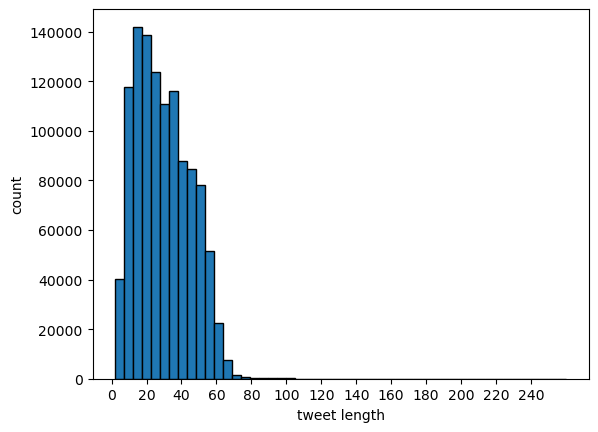

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os #导入os库
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
matplotlib.rcParams['axes.unicode_minus'] = False
my_x_ticks = np.arange(0, 260, 20)

# plt.figure(figsize=(6,4))## 设置画布\n",
plt.xticks(my_x_ticks)
plt.hist(tweet_len,edgecolor="black",bins=50)
plt.xlabel("tweet length")
plt.ylabel("count")
plt.show()

# sns.histplot(tweet_len,kde=True)
# plt.show()


In [8]:
from tqdm import tqdm
classfied_hashtag_list = []
for line in open(r"/home/kayzhou/zhangyue/text/data_GCN/top200.txt","r"):
    classfied_hashtag = line.strip().split(" ")[0]
    classfied_hashtag_list.append(classfied_hashtag)

t = CustomTweetTokenizer(hashtags=classfied_hashtag_list)

save_path = r"/home/kayzhou/zhangyue/text/data_GCN/data_processed/tweet_id_token_10.txt"
f1 = open(save_path,'w',encoding="utf-8")
for tweet_id in tqdm(tweet_id_mapping):
    try:
        tweet = tweet_id_tweet[tweet_id][0]
        word_list = t.tokenize(tweet)
        if len(word_list)==0:
            f1.write(str(tweet_id_mapping[tweet_id])+"\n")
        else:
            f1.write(str(tweet_id_mapping[tweet_id]))
            for word in word_list:
                f1.write(" " + word)
            f1.write("\n")
    except:
        f1.write(str(tweet_id_mapping[tweet_id]) + "\n")
f1.close()
        


100%|██████████| 1123749/1123749 [04:02<00:00, 4631.37it/s]


In [9]:
import pickle
with open(r'/home/kayzhou/zhangyue/text/data_GCN/data_processed/202010_mapping.pkl', "wb") as f:
    pickle.dump([user_id_mapping,tweet_id_mapping], f)
f.close()

In [12]:
# save_path = r"/home/kayzhou/zhangyue/text/data_GCN/data_processed/tweet_id_token_10.txt"
# f1 = open(save_path,'w',encoding="utf-8")
# f1.write("100")
# for i in []:
#     f1.write("100"+str(i) + "\n" + "2")
# f1.close()

In [ ]:
len(tweet_id_token)

In [ ]:
# j=0
# for tweet_id in tweet_id_mapping:
#    j=j+1 
#    if j==89478485 | j==89478486:

#       try:
#          tweet = tweet_id_tweet[tweet_id][0]
#          t = CustomTweetTokenizer(hashtags=classfied_hashtag_list)
#          word_list = t.tokenize(tweet)
#          print(word_list)
#       except:
#             print("no")
      


In [19]:
# import json
# with open(r"/home/kayzhou/zhangyue/text/data_GCN/data_processed/tweet_id_token_10.json", "w",encoding="utf-8") as f:
#     f.write(json.dumps(tweet_id_token))
# f.close()

In [4]:
doc_inputs_raw["372604"][0]

'president'

In [ ]:
#网络数据缺少文本内容，这里只构建单个图神经网络需要的数据
import json
from tqdm import tqdm
tweet_id_tweet = {}
for line in open(r"E:\tweet\202001-train\202001-text.lj","r",encoding="utf8"):
    line= json.loads(line)
    tweet_id=line["tweet_id"]
    tweet_id_tweet[tweet_id]=[line["text"],line["label"]]

# 邻接矩阵构建

In [ ]:
# import numpy as np
# import scipy.sparse as ss
# node_num = len(user_id_list)+len(tweet_id_list)
# A = ss.lil_matrix((node_num,node_num))

In [11]:
#尝试
node_num = len(user_id_list)+len(tweet_id_list)
row = []
col = []
num = []
for user_id in tqdm(user_tweet_id):
    one_user_tweet_id_list = user_tweet_id[user_id]
    for one_tweet_id in one_user_tweet_id_list:
        row.append(user_id_mapping[user_id])
        row.append(tweet_id_mapping[one_tweet_id])
        col.append(tweet_id_mapping[one_tweet_id])
        col.append(user_id_mapping[user_id])
        num.append(1)
        num.append(1)
for user_id in tqdm(user_id_retweeted_user_id):
    retweeted_tweet_id_list = user_id_retweeted_user_id[user_id]
    for one_retweeted_tweet_id in retweeted_tweet_id_list:
        row.append(user_id_mapping[user_id])
        col.append(user_id_mapping[one_retweeted_tweet_id])
        num.append(1)
row = np.asarray(row)
col = np.asarray(col)
num = np.asarray(num)

100%|██████████| 311618/311618 [00:01<00:00, 167770.89it/s]
0it [00:00, ?it/s]


In [12]:
import numpy as np
import scipy.sparse as ss
B = ss.coo_matrix((num, (row, col)), shape=(node_num, node_num), dtype=np.int)

/tmp/ipykernel_187521/3139242656.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = ss.coo_matrix((num, (row, col)), shape=(node_num, node_num), dtype=np.int)


In [53]:
# for user_id in tqdm(user_tweet_id):
#     one_user_tweet_id_list = user_tweet_id[user_id]
#     for one_tweet_id in one_user_tweet_id_list:
#         A[user_id_mapping[user_id],tweet_id_mapping[one_tweet_id]]=1
#         A[tweet_id_mapping[one_tweet_id],user_id_mapping[user_id]]=1

# for user_id in tqdm(user_id_retweeted_user_id):
#     retweeted_tweet_id_list = user_id_retweeted_user_id[user_id]
#     for one_retweeted_tweet_id in retweeted_tweet_id_list:
#         A[user_id_mapping[user_id],user_id_mapping[one_retweeted_tweet_id]]=1

100%|██████████| 6209648/6209648 [04:24<00:00, 23469.09it/s] 


In [55]:
#测试第4个文档转发情况
# print("第四文档")
# for user_id in tqdm(user_tweet_id):
#     one_user_tweet_id_list = user_tweet_id[user_id]
#     for one_tweet_id in one_user_tweet_id_list:
#         if one_tweet_id == '1002555673660612608':
#             print(user_id)
#             print(one_user_tweet_id_list)
# print("第1文档")            
# for user_id in tqdm(user_tweet_id):
#     one_user_tweet_id_list = user_tweet_id[user_id]
#     for one_tweet_id in one_user_tweet_id_list:
#         if one_tweet_id == '1001336753586749441':
#             print(one_user_tweet_id_list)


第四文档


 61%|██████████████████████████████████████████▋                           | 276487/452881 [00:00<00:00, 417161.24it/s]

404128101
{'1214422922254856193', '1002555673660612608'}
982841572302708736
{'1002555673660612608'}


100%|██████████████████████████████████████████████████████████████████████| 452881/452881 [00:00<00:00, 467611.82it/s]


第1文档


 11%|███████▉                                                               | 50340/452881 [00:00<00:01, 256431.91it/s]

{'1214375600023990272', '1214513668936937472', '1214410604020002817', '1214562735087702019', '1214543569484206081', '1214511604697567232', '1214223064231268352', '1214383339626479617', '1214236914666156032', '1214227573800132608', '1214620211854422016', '1214440420094160896', '1214565710875070467', '1214664531517071360', '1214460996678344704', '1214415064582615040', '1213851134898491392', '1214684929352585217', '1214417892881522688', '1214560032353742849', '1214392500485378049', '1214609683484422145', '1214554090098876421', '1214409609584218112', '1214682997502304256', '1214697272992075778', '1214621930013237248', '1214376920932114433', '1214553869713317888', '1214563317911441415', '1214512672944934912', '1214554584015872001', '1214648764335439872', '1214350924526870528', '1214683669081686016', '1214563244125220865', '1214534187073622016', '1214634024527777792', '1214554105282215936', '1214466927151607808', '1214543477305946114', '1214395602638950400', '1213863630279565312', '121440234

100%|██████████████████████████████████████████████████████████████████████| 452881/452881 [00:01<00:00, 408675.00it/s]


In [13]:
doc_label_list = []
mask_idx = []
for index,i in enumerate(tweet_id_list):
    try:
        label_str =  tweet_id_tweet[i][1]
        if label_str == "JB":
            label = 0
        else:
            label = 1
    except:
        print("nonononono")
    doc_label_list.append(label)
            
            
        

In [14]:
len(doc_label_list)

1123749

In [15]:
import random
all_index = list(range(0,len(doc_label_list)))
random.seed(2)
test_index = list(random.sample(all_index,int(len(all_index)*0.1)))
del_test_index =  list(set(all_index)^set(test_index))
random.seed(2)
train_index = list(random.sample(del_test_index,int(len(all_index)*0.8)))
dev_index = list(set(del_test_index)^set(train_index))


In [16]:
all_labels=[0,1]
all_user = [user_id_mapping[i] for i in user_id_mapping]
all_docs = [tweet_id_mapping[i] for i in tweet_id_mapping]

In [17]:
raw_data={"A":[B],"y":doc_label_list,"all_labels":all_labels,'train_idx':train_index,
      "valid_idx":dev_index,"test_idx":test_index,"all_user":all_user,"all_docs":all_docs}

import pickle
with open(r'/home/kayzhou/zhangyue/text/data_GCN/data_processed/one_month_network_202010.pkl', "wb") as f:
    pickle.dump(raw_data, f)

   

In [18]:
f.close()